In [3]:
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.6 MB/s eta 0:00:00a 0:00:01


In [5]:
import numpy as np
import cv2
from shapely.geometry import Polygon

def mask_to_polygons(img_path, mask_path):
    '''
    Convierte una máscara de imagen en polígonos. Devuelve dos listas:
    - Lista de polígonos de shapely sin normalizar
    - Lista de polígonos de shapely normalizados (coordenadas entre 0 y 1)

    Args:
        img_path (str): Ruta al archivo de imagen original.
        mask_path (str): Ruta al archivo de la máscara en escala de grises.
    '''
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Calcula los contornos 
    mask = mask.astype(bool)
    #contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # convertimos los contornos a polígonos de Label Studio
    polygons = []
    normalized_polygons = []
    for contour in contours:
        
        # Lo meto en un try porque la extraccion de polígonos que hace el opencv a partir de la máscara
        # a veces genera polígonos de menos de 4 vértices, que no tiene sentido por no ser cerrados, 
        # provocando que falle al convertir a polígno de shapely

        try:
            polygon = contour.reshape(-1, 2).tolist()
          
            # normalizamos las coordenadas entre 0 y 1 porque así lo requiere YOLOv8
            normalized_polygon = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in polygon]
        
            # Convertimos a objeto poligono de shapely (sin normalizar)
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            # normalizdos
            normalized_polygons.append(Polygon(normalized_polygon))
          

        except Exception as e:
            pass
        

    return polygons, normalized_polygons 

In [6]:
polygons, normalized_polygons = mask_to_polygons("/mnt/DATA/dronetracking/Abhin/segement&detect/U2net/video1/00001.jpg", "/mnt/DATA/dronetracking/Abhin/segement&detect/U2net/video1/osm_0001.png")

In [7]:
normalized_polygons

[<POLYGON ((0.585 0.516, 0.584 0.518, 0.584 0.518, 0.584 0.519, 0.584 0.53, 0...>]

In [3]:
polygons, normalized_polygons

([<POLYGON ((1124 557, 1121 561, 1121 572, 1117 576, 1117 583, 1115 586, 1116 ...>],
 [<POLYGON ((0.585 0.516, 0.584 0.518, 0.584 0.518, 0.584 0.519, 0.584 0.53, 0...>])

In [9]:
import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def draw_polygons_on_image(img_path, polygons, output_path=None):
    '''
    Dibuja polígonos en una imagen y la muestra.
    
    Args:
        img_path (str): Ruta al archivo de imagen original.
        polygons (list): Lista de objetos Polygon de shapely.
    '''
    
    # Carga la imagen
    img = cv2.imread(img_path)
    
    # Escala la imagen si los polígonos están normalizados
    h, w, _ = img.shape

    # Dibuja cada polígono en la imagen
    for polygon in polygons:
        # Orient the polygon counterclockwise to ensure correct drawing
        polygon = orient(polygon, sign=1.0)
        
        # Obtén las coordenadas del polígono y conviértelas a un formato que OpenCV pueda usar
        coords = np.array(polygon.exterior.coords, dtype=np.int32)

        # Dibuja el polígono en la imagen
        cv2.polylines(img, [coords], isClosed=True, color=(0, 255, 0), thickness=10)
    
    # Convertimos la imagen de BGR a RGB para Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

     # Muestra la imagen usando Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    # Guarda la imagen si se proporciona una ruta de salida
    if output_path:
        cv2.imwrite(output_path, img)

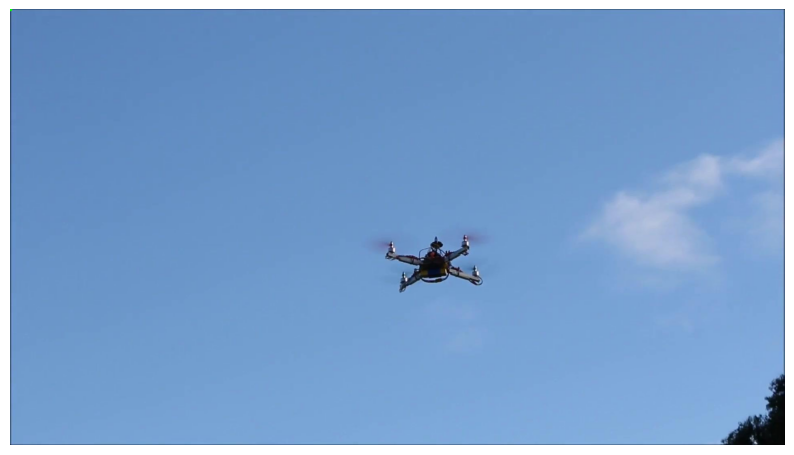

In [10]:
# Dibuja y muestra los polígonos sin normalizar
draw_polygons_on_image("/mnt/DATA/dronetracking/Abhin/segement&detect/U2net/video1/00001.jpg", normalized_polygons, "/mnt/DATA/dronetracking/Abhin/segement&detect/U2net/video1/poligonos.jpg")

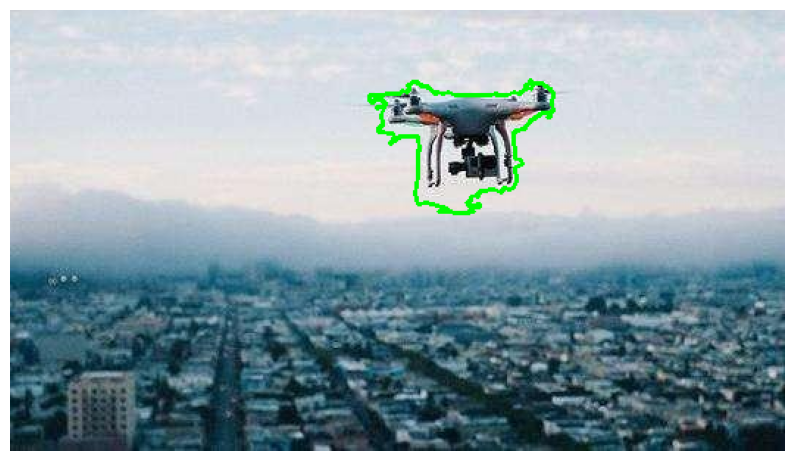

In [4]:
import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def draw_polygons_on_image(img_path, polygons, output_path=None):
    '''
    Dibuja polígonos en una imagen y la muestra.
    
    Args:
        img_path (str): Ruta al archivo de imagen original.
        polygons (list): Lista de objetos Polygon de shapely.
    '''
    
    # Carga la imagen
    img = cv2.imread(img_path)
    
    # Escala la imagen si los polígonos están normalizados
    h, w, _ = img.shape

    # Dibuja cada polígono en la imagen
    for polygon in polygons:
        # Orient the polygon counterclockwise to ensure correct drawing
        polygon = orient(polygon, sign=1.0)
        
        # Obtén las coordenadas del polígono y conviértelas a un formato que OpenCV pueda usar
        coords = np.array(polygon.exterior.coords, dtype=np.int32)

        # Dibuja el polígono en la imagen
        cv2.polylines(img, [coords], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Convertimos la imagen de BGR a RGB para Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Muestra la imagen usando Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
    
    # Guarda la imagen si se proporciona una ruta de salida
    if output_path:
        cv2.imwrite(output_path, img)

def read_polygons_from_file(file_path):
    '''
    Lee las coordenadas de los polígonos desde un archivo de texto y crea una lista de objetos Polygon.
    
    Args:
        file_path (str): Ruta al archivo de texto que contiene las coordenadas.
    
    Returns:
        list: Lista de objetos Polygon de shapely.
    '''
    polygons = []
    with open(file_path, 'r') as file:
        for line in file:
            coords = list(map(int, line.strip().split()))
            if coords[0] == 0:
                coords = coords[1:]  # Ignorar el primer elemento si es 0
            points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
            polygon = Polygon(points)
            polygons.append(polygon)
    return polygons

# Ejemplo de uso
img_path = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_DUT/val/img/00001.jpg'           # Reemplaza con la ruta a tu imagen
polygon_file_path = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_DUT/val/mask_polygon/polygons/00001.txt'  # Reemplaza con la ruta a tu archivo de coordenadas
output_path = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_DUT/val/mask_polygon/img_polygon_00001.jpg'  # Reemplaza con la ruta de salida

# Leer polígonos desde el archivo
polygons = read_polygons_from_file(polygon_file_path)

# Dibujar polígonos en la imagen
draw_polygons_on_image(img_path, polygons, output_path)


In [2]:
import os
import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def draw_polygons_on_image(img_path, polygons, output_path):
    '''
    Dibuja polígonos en una imagen y la guarda.
    
    Args:
        img_path (str): Ruta al archivo de imagen original.
        polygons (list): Lista de objetos Polygon de shapely.
        output_path (str): Ruta para guardar la imagen resultante.
    '''
    
    # Carga la imagen
    img = cv2.imread(img_path)
    
    # Dibuja cada polígono en la imagen
    for polygon in polygons:
        # Orient the polygon counterclockwise to ensure correct drawing
        polygon = orient(polygon, sign=1.0)
        
        # Obtén las coordenadas del polígono y conviértelas a un formato que OpenCV pueda usar
        coords = np.array(polygon.exterior.coords, dtype=np.int32)

        # Dibuja el polígono en la imagen
        cv2.polylines(img, [coords], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Guarda la imagen resultante
    cv2.imwrite(output_path, img)

def read_polygons_from_file(file_path):
    '''
    Lee las coordenadas de los polígonos desde un archivo de texto y crea una lista de objetos Polygon.
    
    Args:
        file_path (str): Ruta al archivo de texto que contiene las coordenadas.
    
    Returns:
        list: Lista de objetos Polygon de shapely.
    '''
    polygons = []
    with open(file_path, 'r') as file:
        for line in file:
            coords = list(map(int, line.strip().split()))
            if coords[0] == 0:
                coords = coords[1:]  # Ignorar el primer elemento si es 0
            points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
            polygon = Polygon(points)
            polygons.append(polygon)
    return polygons

def process_images_and_polygons(img_folder, polygon_folder, output_folder):
    '''
    Procesa todas las imágenes y archivos de polígonos, dibuja los polígonos en las imágenes
    y guarda las imágenes resultantes en una carpeta de salida.
    
    Args:
        img_folder (str): Ruta a la carpeta que contiene las imágenes.
        polygon_folder (str): Ruta a la carpeta que contiene los archivos de polígonos.
        output_folder (str): Ruta a la carpeta donde se guardarán las imágenes resultantes.
    '''
    # Asegúrate de que la carpeta de salida exista
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Obtén una lista de archivos de imágenes y archivos de polígonos
    img_files = sorted([f for f in os.listdir(img_folder) if os.path.isfile(os.path.join(img_folder, f))])
    polygon_files = sorted([f for f in os.listdir(polygon_folder) if os.path.isfile(os.path.join(polygon_folder, f))])
    
    # Procesa cada imagen y su archivo de polígonos correspondiente
    for img_file, polygon_file in zip(img_files, polygon_files):
        img_path = os.path.join(img_folder, img_file)
        polygon_path = os.path.join(polygon_folder, polygon_file)
        output_path = os.path.join(output_folder, img_file)
        
        # Leer polígonos desde el archivo
        polygons = read_polygons_from_file(polygon_path)
        
        # Dibujar polígonos en la imagen y guardar el resultado
        draw_polygons_on_image(img_path, polygons, output_path)

# Ejemplo de uso
img_folder = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_dataset/train/img'            # Reemplaza con la ruta a la carpeta de imágenes
polygon_folder = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_dataset/polygons'       # Reemplaza con la ruta a la carpeta de archivos de polígonos
output_folder = '/mnt/DATA/dronetracking/Abhin/segement&detect/detection_dataset/image_with_polygon'           # Reemplaza con la ruta a la carpeta de salida

# Procesar imágenes y polígonos
process_images_and_polygons(img_folder, polygon_folder, output_folder)
